# Implementing QuartzNet

In [2]:
import torch
import torchaudio
import pandas as pd
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
# %pylab inline
# from itertools import islice
# from scipy.signal import hann
# from scipy.io import wavfile


In [3]:
path_to_dataset = "../resources/LJSpeech-1.1/"
path_to_metadata = path_to_dataset + "metadata.csv"
batch_size = 32
n_mels = 64
B = 3
R = 5

freq_mask_param = 20
time_mask_param = 20

column_names = ['wav_filename', 'text_with_numbers', 'text_in_letters'] 
max_str_len = 100

In [4]:
def filter_non_ascii(string):
    try:
        str(string).encode('ascii')
    except UnicodeEncodeError:
        return False

    return True

In [5]:
LJdata = pd.read_csv(path_to_metadata, sep='|', names=column_names, header=None)
LJdata.drop(columns=['text_with_numbers'], inplace=True)
LJdata['text_in_letters'] = LJdata['text_in_letters'].apply(lambda x: str(x))
LJdata = LJdata[LJdata['text_in_letters'].apply(lambda x: len(x) <= max_str_len)]
LJdata = LJdata[LJdata['text_in_letters'].apply(filter_non_ascii)]

In [6]:
LJdata

wav_filename                                    text_in_letters
1       LJ001-0002                     in being comparatively modern.
3       LJ001-0004  produced the block books, which were the immed...
5       LJ001-0006  And it is worth mention in passing that, as an...
7       LJ001-0008                          has never been surpassed.
10      LJ001-0011  it is of the first importance that the letter ...
...            ...                                                ...
13085   LJ050-0264  The Commission recommends that the present arr...
13087   LJ050-0266  The exchange of letters dated August thirty-on...
13090   LJ050-0269  The essential terms of such memoranda might we...
13094   LJ050-0273  The Commission has, however, from its examinat...
13095   LJ050-0274  made certain recommendations which it believes...

[6317 rows x 2 columns]

In [7]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=n_mels)

In [8]:
class MyDataset(Dataset):
    def __getitem__(self, index: int):
        wav_filename, text_in_letters = LJdata.iloc[index]
        path_to_file = path_to_dataset + "wavs/" + wav_filename + ".wav"

        waveform, sample_rate = torchaudio.load(path_to_file)
        
        spectrogram = torch.log(mel_transform(waveform) + 1e-9)

        return spectrogram, text_in_letters  # , spectrogram.shape[-1] // 2, len(text_in_letters)

    def __len__(self):
        return len(LJdata)

In [9]:
my_dataset = MyDataset()

6317
in being comparatively modern.
30
82


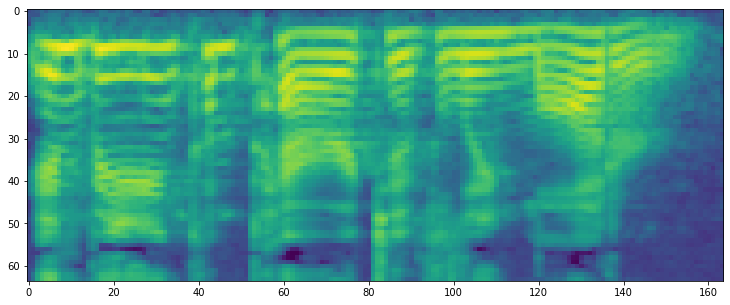

In [10]:
spec, lbl = my_dataset.__getitem__(0)
print(len(my_dataset))
print(lbl)
print(len(lbl))
print(spec.shape[-1] // 2)

plt.figure(figsize=(20, 5))
plt.imshow(spec.squeeze())
plt.show()

In [11]:
dataset_length = len(my_dataset)
train_dataset_length = int(dataset_length * 0.95)
test_dataset_length = dataset_length - train_dataset_length

train_dataset, test_dataset = random_split(
    dataset=my_dataset,
    lengths=[train_dataset_length, test_dataset_length],
    generator=torch.Generator().manual_seed(21)
)

In [12]:
def augment(waveform):
    freq_transform = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    time_transform = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    return time_transform(freq_transform(waveform))

In [13]:
char2int = {
        '#': 0,
        ' ': 1,
        'a': 2,
        'b': 3,
        'c': 4,
        'd': 5,
        'e': 6,
        'f': 7,
        'g': 8,
        'h': 9,
        'i': 10,
        'j': 11,
        'k': 12,
        'l': 13,
        'm': 14,
        'n': 15,
        'o': 16,
        'p': 17,
        'q': 18,
        'r': 19,
        's': 20,
        't': 21,
        'u': 22,
        'v': 23,
        'w': 24,
        'x': 25,
        'y': 26,
        'z': 27
    }

int2char = {
        0: '#',
        1: ' ',
        2: 'a',
        3: 'b',
        4: 'c',
        5: 'd',
        6: 'e',
        7: 'f',
        8: 'g',
        9: 'h',
        10: 'i',
        11: 'j',
        12: 'k',
        13: 'l',
        14: 'm',
        15: 'n',
        16: 'o',
        17: 'p',
        18: 'q',
        19: 'r',
        20: 's',
        21: 't',
        22: 'u',
        23: 'v',
        24: 'w',
        25: 'x',
        26: 'y',
        27: 'z'
    }    

In [14]:
def text_transform(text_in_letters):
    int_array = []
    for c in text_in_letters:
        if c in char2int:
            int_array.append(char2int[c])
        
    return int_array

In [15]:
def collate_sequences(batch, is_test = False):
    specs = []
    labels = []
    for (log_mel_spec, text_in_letters) in batch:
        if not is_test:
            log_mel_spec = augment(log_mel_spec)
        specs.append(log_mel_spec.squeeze(0).transpose(0, 1))
        text_in_ints = torch.Tensor(text_transform(text_in_letters))
        labels.append(text_in_ints)

    specs = nn.utils.rnn.pad_sequence(sequences=specs, batch_first=True).transpose(1, 2)
    labels = nn.utils.rnn.pad_sequence(sequences=labels, batch_first=True)

    return specs, labels

In [16]:
train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            collate_fn=collate_sequences,
            num_workers=4
        )

test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            collate_fn=collate_sequences,
            num_workers=4
        )

0 tensor([[ 2., 21.,  1.,  ...,  0.,  0.,  0.],
        [ 1., 19.,  6.,  ...,  0.,  0.,  0.],
        [ 2., 15.,  5.,  ...,  0.,  0.,  0.],
        ...,
        [ 2.,  7.,  7.,  ...,  0.,  0.,  0.],
        [ 9.,  6., 19.,  ...,  0.,  0.,  0.],
        [ 9.,  6.,  1.,  ...,  0.,  0.,  0.]])
torch.Size([32, 64, 562])


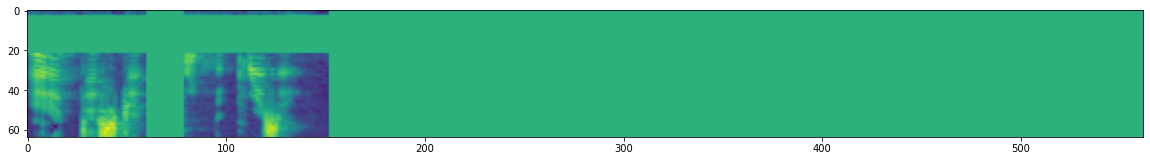

100 tensor([[ 9.,  6.,  1.,  ...,  0.,  0.,  0.],
        [22.,  4.,  9.,  ...,  0.,  0.,  0.],
        [15.,  6.,  1.,  ...,  0.,  0.,  0.],
        ...,
        [ 2., 15.,  5.,  ...,  0.,  0.,  0.],
        [ 9.,  6.,  1.,  ...,  0.,  0.,  0.],
        [ 9.,  6., 10.,  ...,  0.,  0.,  0.]])
torch.Size([32, 64, 674])


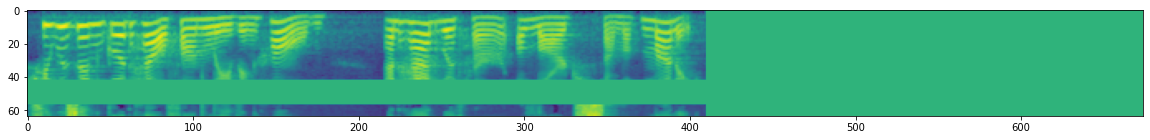

In [17]:
# mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)

for i, (log_mel_spec, text_in_ints) in enumerate(train_dataloader):
    if (i % 100 == 0):
        print(i, text_in_ints)
        print(log_mel_spec.shape)
        plt.figure(figsize=(20, 5))
        plt.imshow(log_mel_spec[0].squeeze())
        plt.show()


In [18]:
class Conv_BN_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride = 1):
        super(Conv_BN_ReLU, self).__init__()
        
        self.cnn = nn.Conv1d(in_channels, out_channels, kernel, stride=stride)  # , padding=kernel//2)
        
        self.batch_norm = nn.modules.batchnorm.BatchNorm1d(num_features=out_channels)
        
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        x = self.cnn(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x  # (batch, channel, feature, time)

In [19]:
# k = 10  # depthwise multiplier

class TCSConv_BN_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel):
        super(TCSConv_BN_ReLU, self).__init__()

        self.depthwise_conv = nn.Conv1d(in_channels, in_channels * kernel, kernel_size=kernel)
        
        self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0, bias=False)
        
        self.batch_norm = nn.modules.batchnorm.BatchNorm1d(num_features=out_channels)
        
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x  # (batch, channel, feature, time)

In [22]:
class TCSBlock(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self):
        super(TCSBlock, self).__init__()
        
        self.TCS_layer_1 = TCSConv_BN_ReLU(in_channels=256, out_channels=256, kernel=33)
        self.TCS_layer_2 = TCSConv_BN_ReLU(in_channels=256, out_channels=256, kernel=39)
        self.TCS_layer_3 = TCSConv_BN_ReLU(in_channels=256, out_channels=512, kernel=51)
        self.TCS_layer_4 = TCSConv_BN_ReLU(in_channels=512, out_channels=512, kernel=63)
        self.TCS_layer_5 = TCSConv_BN_ReLU(in_channels=512, out_channels=512, kerne=75)
        
    def forward(self, x):
        # x (batch, channel, feature, time)
        x_copy = x
        x = TCS_layer_1(x)
        x = TCS_layer_2(x)
        x = TCS_layer_3(x)
        x = TCS_layer_4(x)
        x = TCS_layer_5(x)
        x += x_copy
        return x  # (batch, channel, feature, time)

In [93]:
# class MainBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel, stride, n_feats):
#         super(MainBlock, self).__init__()
        
#         self.main_layers = nn.Sequential(*[
#             TCSBlock(in_channels, out_channels, kernel, stride, n_feats)
#             for i in range(B)
#         ])
#     def forward(self, x):
#         # x (batch, channel, feature, time)
#         x = TCS_layers(x)
#         return x  # (batch, channel, feature, time)

In [24]:
class ASR(nn.Module):
    def __init__(self):
        super(ASR, self).__init__()
        
        self.conv_bn_relu_1 = Conv_BN_ReLU(in_channels=64, out_channels=256, kernel=33, stride=2)
        self.main_block = nn.Sequential(*[
            TCSBlock()
            for i in range(B)
        ])
        self.conv_bn_relu_2 = Conv_BN_ReLU(in_channels=512, out_channels=512, kernel=87)
        self.conv_bn_relu_3 = Conv_BN_ReLU(in_channels=512, out_channels=1024, kernel=1)
        self.conv_bn_relu_4 = nn.Conv1d(in_channels=1024, out_channels=len(char2int), kernel_size=1, padding=0, dilation=2, bias=False)
    
    def forward(self, x):
        # x (batch, channel, feature, time)
        x = conv_bn_relu_1(x)
        x = main_block(x)
        x = conv_bn_relu_2(x)
        x = conv_bn_relu_3(x)
        x = conv_bn_relu_4(x)
        return x  # (batch, channel, feature, time)

In [ ]:
model=ASR()

In [109]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

NameError: name 'model' is not defined

    Следующая компонента это сама модель. Для примера просто возьмем сеть из туториал.

In [ ]:
from torch import nn
import torch.nn.functional as F


class Reshape(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        # X.shape == [B, C, H, W] -> [B, H']
        return torch.flatten(x, start_dim=1)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Reshape(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
            nn.Linear(84, 10),
        )
        
    def forward(self, x):
        return self.net(x)


net = Net()
device = torch.device('cpu')
net = net.to(device)
net = net.train()

    Определяем функцию потерь и метод оптимизации

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,
                      nesterov=True, weight_decay=1e-5)

    И последняя компанента пайплайна это написание train/val loop-ов. В данном случае тут все просто, но
    в больших задачах эта часть занимает много времени и кода :( Стоит присмотреться в библиотекам, которые
    это делают за нас, например, pytorch-lighting

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

    Посмотрим качество классификации на одном тестовом батче

# torchaudio

    Немного познакомимся с torchaudio -- аналог torchvision, но для звука. torchaudio предоставляется возможность считать
    STFT (short-time Fourier transform), Spectrograms, MelSpectrograms, а также много чего еще.

In [5]:
import torchaudio
from scipy.signal import hann
from scipy.io import wavfile

    Считаем wav файл и посмотрим как он выглядит

In [6]:
filename = "../resources/audio.wav"
waveform, sample_rate = torchaudio.load(filename)

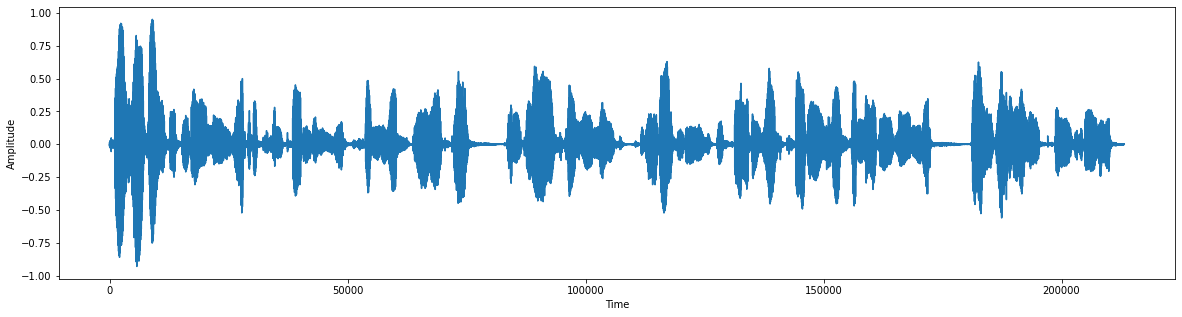

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(waveform.squeeze())
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()